In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')

path.mkdir(exist_ok=True)

In [8]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [9]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [10]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [11]:
list(path.glob('*')) # list all files

[PosixPath('/data/s4314719/image-captioning/__MACOSX'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.trainImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_Dataset.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.lemma.token.txt'),
 PosixPath('/data/s4314719/image-captioning/ExpertAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/readme.txt'),
 PosixPath('/data/s4314719/image-captioning/Flicker8k_Dataset'),
 PosixPath('/data/s4314719/image-captioning/CrowdFlowerAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.testImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.token.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_text.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.devImages.txt')]

In [12]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


In [24]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class FlickrDataset(Dataset):
    def __init__(self, img_dir, ann_file, img_ids, trnsf=None):
        self.img_dir = Path(img_dir)
        self.ann_file = Path(ann_file)
        self.trnsf = trnsf
        self.annotations = {}
        
        img_ids = Path(img_ids).read_text().split('\n')
        for line in sorted(ann_file.read_text().split('\n')):
            if len(line) == 0:
                continue
            img_id, annotation = line.split('\t')
            img_id = re.match(r'.*\.jpg', img_id).group(0)  
            if not ((img_dir/img_id).exists() and img_id in img_ids):
                continue
            if annotation not in self.annotations: # only consider the first of 5 annotations
                self.annotations.update({img_id: annotation})                  
        self.img_ids = sorted(list(self.annotations.keys()))
        
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        annotation = self.annotations[img_id]
        im = Image.open(self.img_dir/img_id)
        if self.trnsf is not None:
            im = self.trnsf(im)
        return im, annotation

### Preprocessing the images

In [14]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
mean = np.array([0.4629, 0.4468, 0.4050])
std = np.array([0.2661, 0.2587, 0.2727])

In [15]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

### Split data up into train and evaluation set

In [25]:
# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, ann_file,  path/'Flickr_8k.trainImages.txt', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, ann_file, path/'Flickr_8k.devImages.txt', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

(6000, 1000)

### Preprocessing and tokenizing the captions

#### Goal: Building a dictionary of each word in the training set

In [28]:
from src.preprocessing import preprocess

train_sequences, known_words_final, max_length = preprocess(ds_train)

### Visualizing some images

In [25]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)

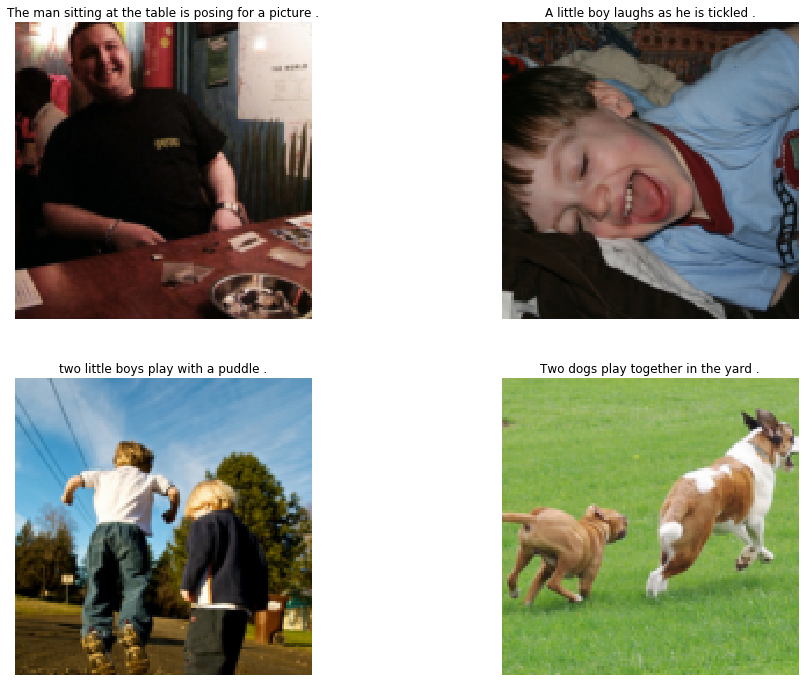

In [26]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(caption)
    imshow(im)
    plt.axis('off')

### Model initialization and training

In [48]:
# dummy variables
dict_size = 10000
num_hidden = 512
embedding_dim = 512
batch_size = 128
lr = 0.01

In [49]:
from src.models import EncoderDecoder, LSTMDecoder, get_encoder

encoder = get_encoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, dict_size)
model = EncoderDecoder(encoder, decoder, device)

In [64]:
model

EncoderDecoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [35]:
optimizer = optim.Adam(model.parameters())

In [73]:
from src.trainer import Trainer, TrainerConfig

config = TrainerConfig(batch_size=128, epochs=10, num_workers=8)
trainer = Trainer(config, model, optimizer, ds_train, ds_eval)

In [76]:
# This part is not functioning yet
trainer.train()

TypeError: forward() missing 1 required positional argument: 'batch_size'